In [1]:
from datetime import datetime

# Settings up paths

In [4]:
from pathlib import Path
DATA_PATH = Path('../data/gtzan')
RESULTS_PATH = Path('../results/gtzan')
PLOTS_PATH = Path('../plots/gtzan')

# Loading data

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv(DATA_PATH/'features_30_sec.csv').drop(['filename', 'length'], axis=1)
y = df.pop('label')
X = df.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

# ML Classification

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
import winsound

## Pipeline

In [19]:
scoring = make_scorer(accuracy_score)
scaler = StandardScaler()
pipeline = Pipeline(steps=[("scaler", scaler), ('clf', DecisionTreeClassifier())])

## Param grid

In [8]:
param_grid = [
    {
        "clf": [DecisionTreeClassifier()],
        "clf__criterion": ["gini", "entropy"],
        "clf__max_depth": [2, 3, 5, 10, None],
        "clf__min_samples_leaf": [1, 5, 10, 20, 30],
    },
    {
        "clf": [SVC()],
        "clf__kernel": ["rbf", "poly", "sigmoid"],
        "clf__gamma": [1, 0.1, 0.01, 0.001],
        "clf__C": [0.1, 1, 10, 100],
    },
    {
        "clf": [SVC()], 
        "clf__kernel": ["linear"], 
        "clf__C": [0.1, 1, 10, 100]
    },
    {
        "clf": [RandomForestClassifier()],
        "clf__criterion": ["entropy", "gini"],
        "clf__max_depth": [1, 5, 10, 20, 30],
        "clf__min_samples_leaf": [1, 5, 10, 20, 30],
    },
]

## Grid search CV

In [9]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    verbose=1,
    scoring="accuracy",
)

In [10]:
grid_search.fit(X_train, y_train)
winsound.Beep(500, 1000)

Fitting 5 folds for each of 152 candidates, totalling 760 fits


# Plots

## Prepare results data

In [11]:
columns = ['params', 'mean_test_score', 'mean_fit_time', 'std_test_score']
cv_df = pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')[columns].reset_index(drop=True)
cv_df = cv_df.join(cv_df.pop('params').apply(pd.Series))
cv_df.clf = cv_df.clf.apply(lambda x: x.__str__().split('(')[0].replace('Classifier', '')).astype("category")
cv_df.head(3)

,mean_test_score,mean_fit_time,std_test_score,clf,clf__C,clf__gamma,clf__kernel,clf__criterion,clf__max_depth,clf__min_samples_leaf
0,0.73625,0.046403,0.013919,SVC,10.0,0.010,rbf,NaN,NaN,NaN
1,0.72375,0.031199,0.014470,SVC,100.0,0.001,rbf,NaN,NaN,NaN
2,0.72125,0.043195,0.014031,SVC,100.0,0.010,rbf,NaN,NaN,NaN


## Plot style

In [12]:
import matplotlib.pyplot as plt
print(plt.style.available)
plt.style.use('seaborn-paper')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


## Plot accuracy

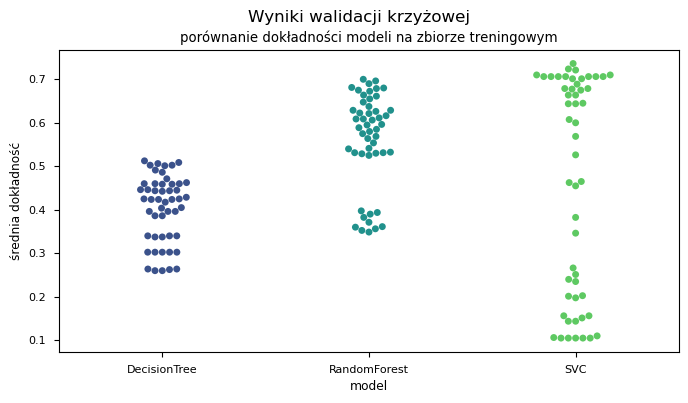

In [13]:
import seaborn as sns 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,4), dpi=100)
sns.swarmplot(x="clf", y="mean_test_score", data=cv_df, palette='viridis', ax=ax)
plt.xlabel('model')
plt.ylabel('średnia dokładność')
plt.suptitle('Wyniki walidacji krzyżowej')
plt.title('porównanie dokładności modeli na zbiorze treningowym')

curent_timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
plt.savefig(PLOTS_PATH/f'gridsearch_acc_comparison_ml_{curent_timestamp}.png')

## Plot training time

C:\Users\barto\.conda\envs\musicai\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 9.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


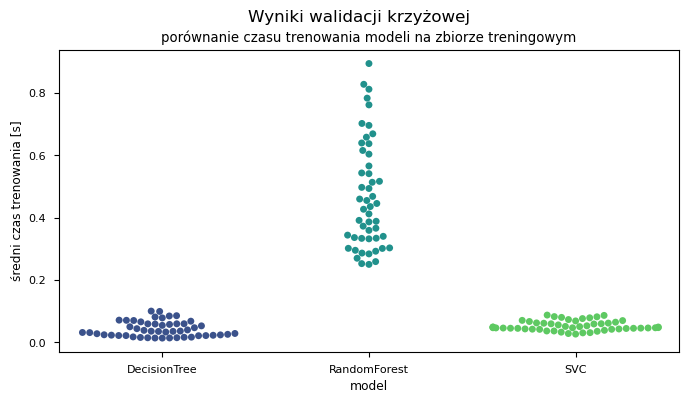

In [14]:
fig, ax = plt.subplots(figsize=(8,4), dpi=100)
sns.swarmplot(x="clf", y="mean_fit_time", data=cv_df, palette='viridis', ax=ax)
plt.xlabel('model')
plt.ylabel('średni czas trenowania [s]')
plt.suptitle('Wyniki walidacji krzyżowej')
plt.title('porównanie czasu trenowania modeli na zbiorze treningowym')

curent_timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
plt.savefig(PLOTS_PATH/f'time_comparison_ml_{curent_timestamp}.png')

## Plot confusion matrix

In [15]:
from sklearn.base import clone

best_model = clone(grid_search.best_estimator_)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

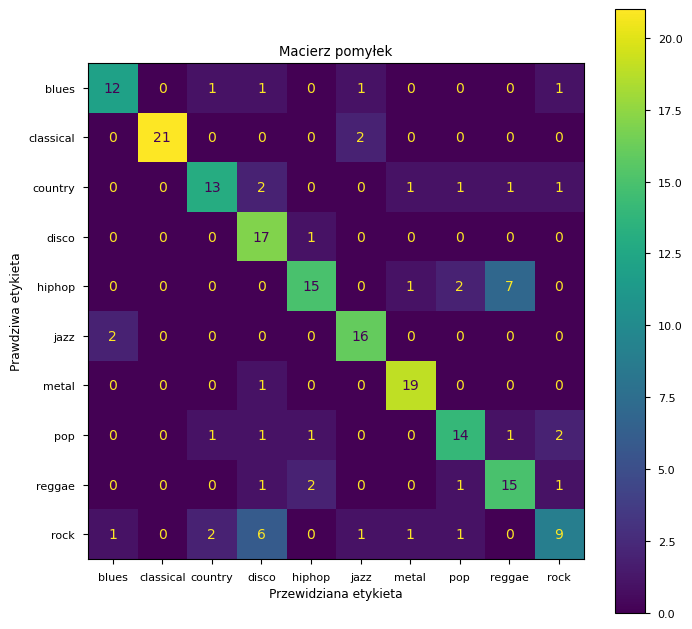

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
fig, ax = plt.subplots(figsize=(8,8), dpi=100)
disp.plot(ax=ax, colorbar=True)
plt.xlabel('Przewidziana etykieta')
plt.ylabel('Prawdziwa etykieta')
# plt.suptitle('Macież pomyłek')
plt.title('Macierz pomyłek')

curent_timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
plt.savefig(PLOTS_PATH/f'confusion_matrix_ml_{curent_timestamp}.png')

# Save Results

In [17]:
from datetime import datetime # Current date time in local system print()
curent_timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
cv_df.to_csv(RESULTS_PATH/f'cv_results_tabular_data_{curent_timestamp}.csv', index=False)

In [18]:
print(curent_timestamp)

2022_04_26_15_26_19
